In [17]:
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import itertools
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adamax

In [6]:
# ------------------------------
# ----- importing the data -----
# ------------------------------
data_dir = "../../data/brain-tumor"
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)

        filepaths.append(str(fpath))
        labels.append(str(fold))

Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis=1)

In [7]:
strat = df['labels']
train_df, test_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=123, stratify=strat)

In [8]:
# ------------------------------
# ----- preparing the data -----
# ------------------------------
batch_size = 8
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                       class_mode='categorical',
                                       color_mode='rgb', shuffle=True, batch_size=batch_size)

test_gen = ts_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                      class_mode='categorical',
                                      color_mode='rgb', shuffle=False, batch_size=batch_size)


Found 202 validated image filenames belonging to 2 classes.
Found 51 validated image filenames belonging to 2 classes.


/Users/vladt/miniconda3/envs/metal/lib/python3.10/site-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 2 invalid image filename(s) in x_col="filepaths". These filename(s) will be ignored.
  warnings.warn(


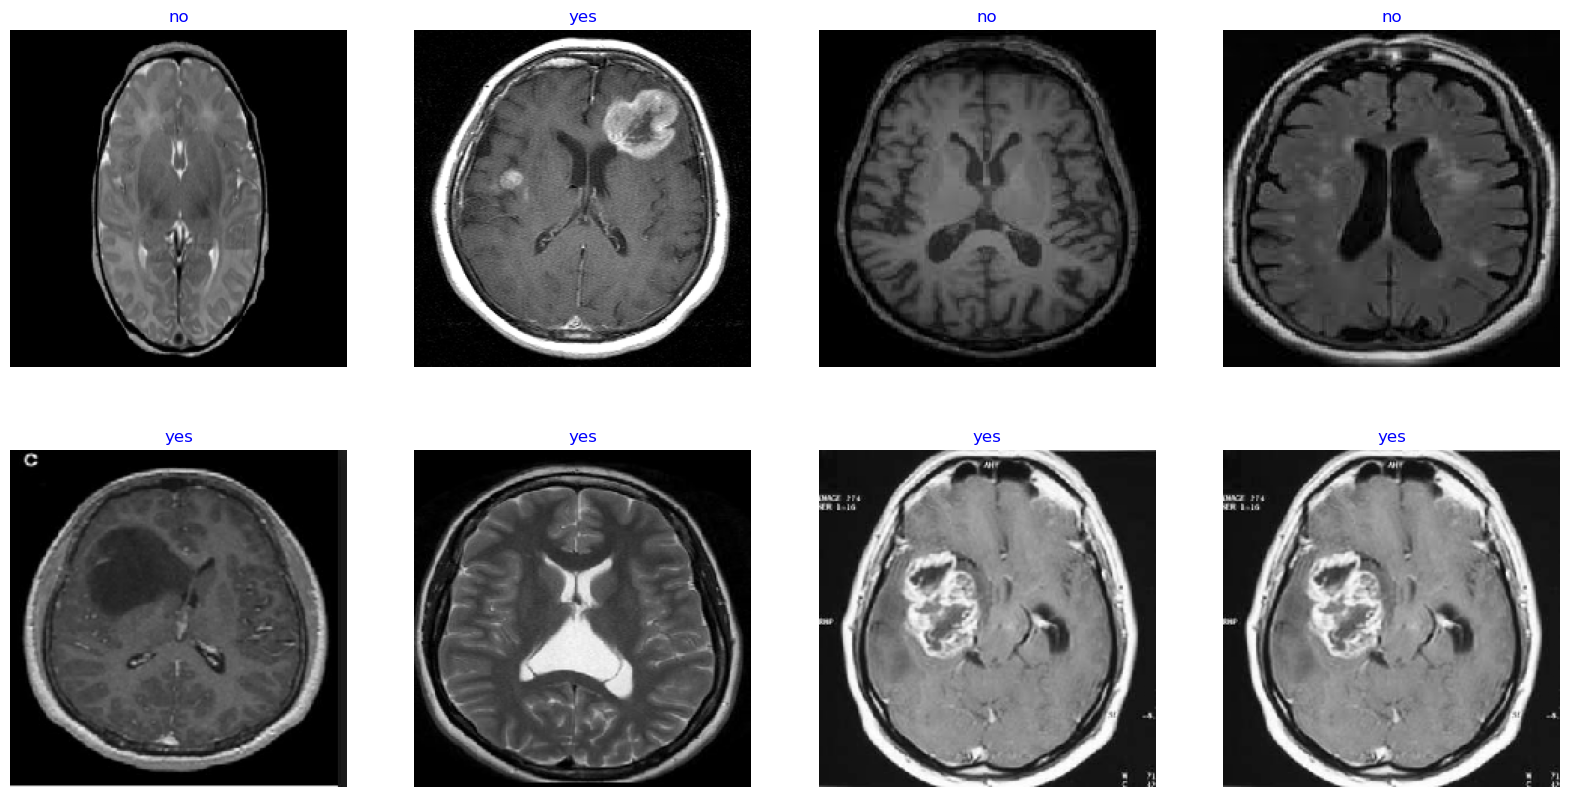

In [9]:
# ---------------------------------
# ----- showing some examples -----
# ---------------------------------
g_dict = train_gen.class_indices  # defines dictionary {'class': index}
classes = list(g_dict.keys())  # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)  # get a batch size samples from the generator

plt.figure(figsize=(20, 10))

for i in range(8):
    plt.subplot(2, 4, i + 1)
    image = images[i] / 255  # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]  # get class of image
    plt.title(class_name, color='blue', fontsize=12)
    plt.axis('off')
plt.show()


In [10]:
# ------------------------------
# ----- creating the model -----
# ------------------------------

# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))  # to define number of classes in dense layer

# create pre-trained model (you can built on pretrained model such as :  efficientnet, VGG , Resnet )
# we will use efficientnetb3 from EfficientNet family.
base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top=False, weights="imagenet",
                                                               input_shape=img_shape, pooling='max')

model = Sequential([
    base_model,
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    Dense(256,
          kernel_regularizer=regularizers.l2(0.016),
          activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006),
          activation='relu'),
    Dropout(rate=0.45, seed=123),
    Dense(class_count, activation='softmax')
])

2025-04-05 11:38:02.342183: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-04-05 11:38:02.342400: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-04-05 11:38:02.342419: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-04-05 11:38:02.342701: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-05 11:38:02.342731: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [11]:
model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)     │ (None, 1536)           │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1536)           │         6,144 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       393,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,183,665 (42.66 MB)

 Trainable params: 11,093,290 (42.32 MB)

 Non-trainable params: 90,375 (353.03 KB)

In [12]:
epochs = 30  # number of all epochs in training

history = model.fit(x=train_gen, epochs=epochs, verbose=1, validation_data=test_gen,
                    validation_steps=None, shuffle=False)

Epoch 1/30


/Users/vladt/miniconda3/envs/metal/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2025-04-05 11:38:25.333356: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


26/26 ━━━━━━━━━━━━━━━━━━━━ 165s 3s/step - accuracy: 0.6005 - loss: 20.8231 - val_accuracy: 0.3922 - val_loss: 33.9116
Epoch 2/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.7554 - loss: 17.1522 - val_accuracy: 0.6863 - val_loss: 23.5327
Epoch 3/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.8315 - loss: 11.8507 - val_accuracy: 0.7255 - val_loss: 15.7400
Epoch 4/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step - accuracy: 0.7884 - loss: 10.6832 - val_accuracy: 0.7843 - val_loss: 15.0173
Epoch 5/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 0.7995 - loss: 9.5784 - val_accuracy: 0.8627 - val_loss: 12.3649
Epoch 6/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.8149 - loss: 9.3377 - val_accuracy: 0.8039 - val_loss: 10.5341
Epoch 7/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.7666 - loss: 8.9664 - val_accuracy: 0.8235 - val_loss: 9.5994
Epoch 8/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 0.7434 - loss: 9.0065 - val_accuracy: 0.8039 - val_loss:

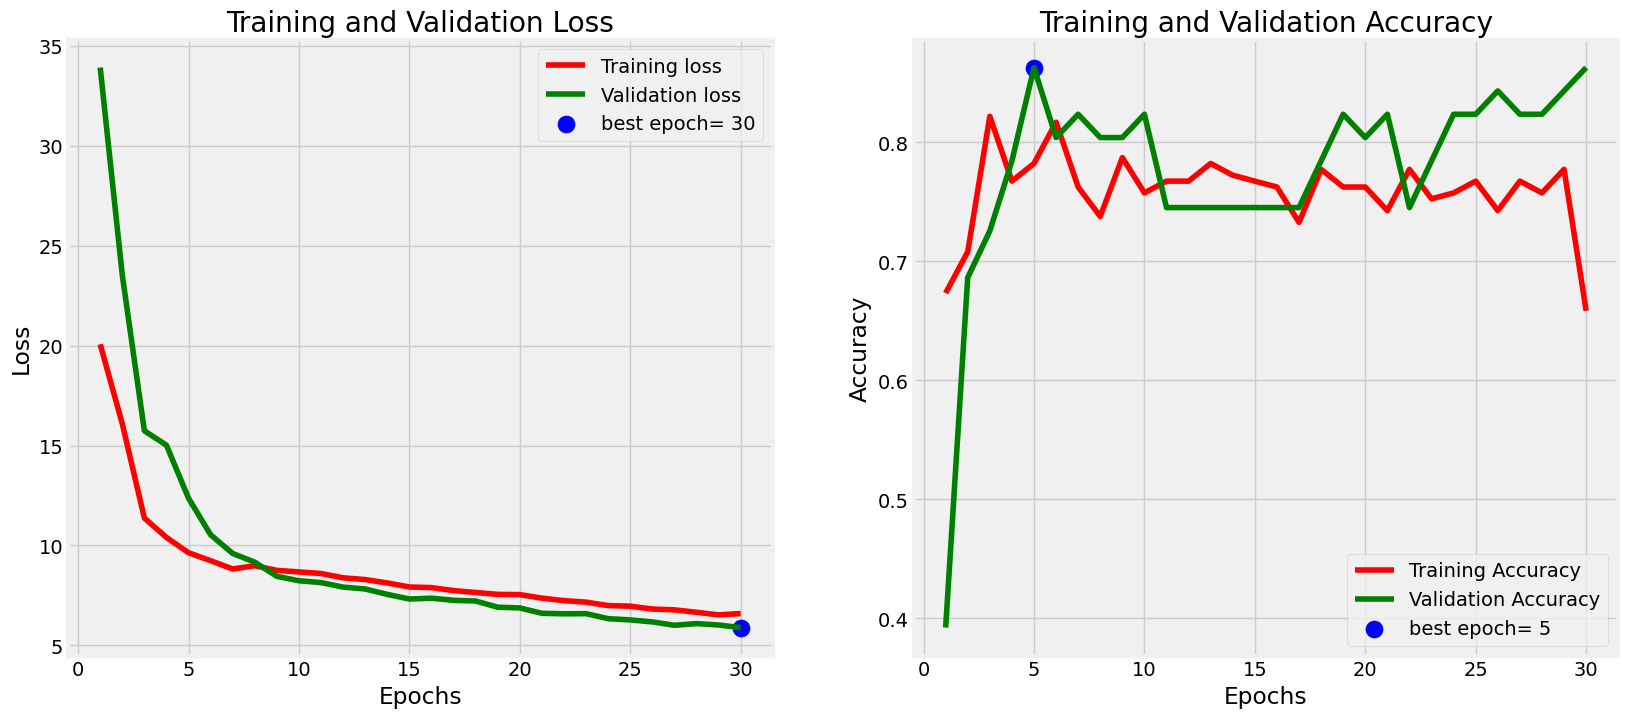

In [13]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [14]:
train_score = model.evaluate(train_gen, verbose= 1)
test_score = model.evaluate(test_gen, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 286ms/step - accuracy: 0.8307 - loss: 6.8964
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.8922 - loss: 5.9170
Train Loss:  6.576908588409424
Train Accuracy:  0.8564356565475464
--------------------
Test Loss:  5.891711711883545
Test Accuracy:  0.8627451062202454


In [15]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 800ms/step


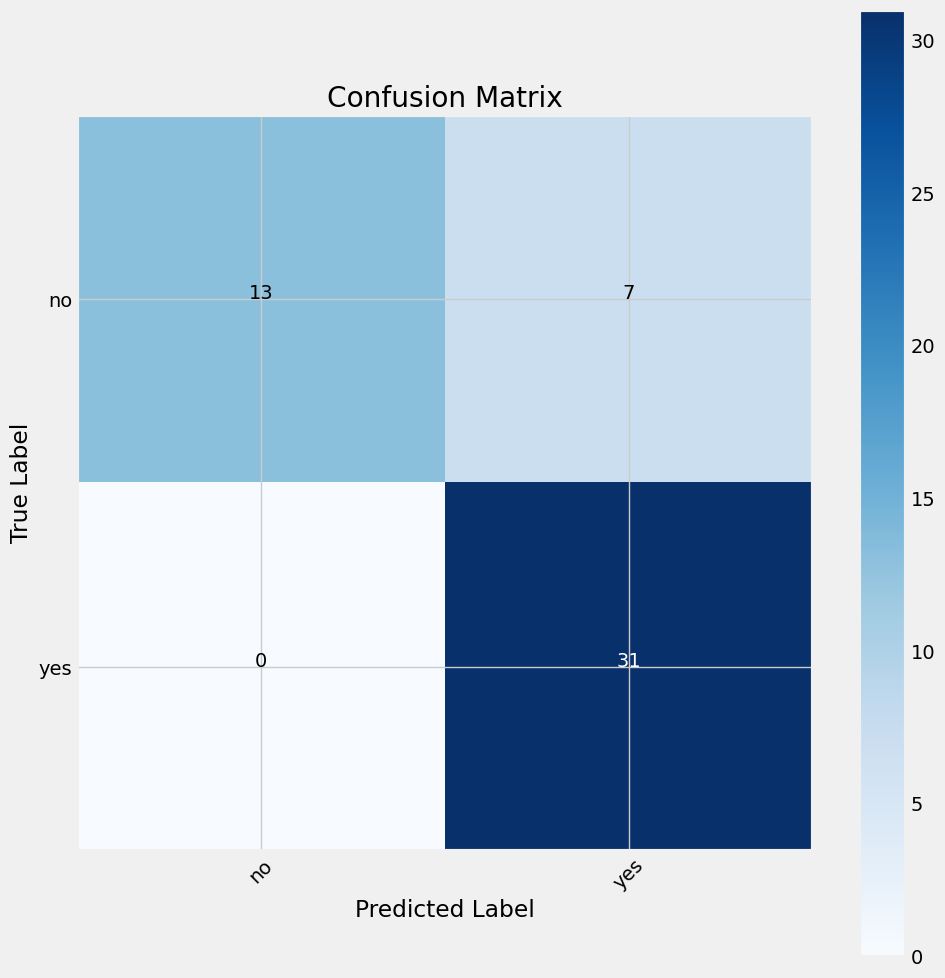

In [18]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [19]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

          no       1.00      0.65      0.79        20
         yes       0.82      1.00      0.90        31

    accuracy                           0.86        51
   macro avg       0.91      0.82      0.84        51
weighted avg       0.89      0.86      0.86        51



In [20]:
#Save the model
model.save('mac-model.h5')

In [54]:
# ----- testing the model -----
from tensorflow.keras.preprocessing import image
import numpy as np

# Load and resize image (adjust size to your model input, e.g., 224x224)
img = image.load_img("images/tumor3.png", target_size=(224, 224))

# Convert to array and scale if needed
img_array = image.img_to_array(img)
img_array = img_array / 255.0  # Only if model was trained on normalized images

# Add batch dimension
img_batch = np.expand_dims(img_array, axis=0)

In [55]:

model2 = tf.keras.models.load_model('models/colab-Model.h5')
pred = model2.predict(img_batch)
print(pred)

predicted_class = classes[np.argmax(pred, axis=1)[0]]
print(f"Predicted class index: {predicted_class}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
[[0.5056011 0.4943989]]
Predicted class index: no
